In [1]:
#INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
#
#Copyright © 2021 Intel Corporation.
#
#This software and the related documents are Intel copyrighted
#materials, and your use of them is governed by the express
#license under which they were provided to you (License). Unless
#the License provides otherwise, you may not use, modify, copy,
#publish, distribute, disclose or transmit  this software or the
#related documents without Intel's prior written permission.
#
#This software and the related documents are provided as is, with
#no express or implied warranties, other than those that are
#expressly stated in the License.

# Import modules

In [2]:
# Import modules
import os
import sys
sys.path.append('/homes/lyes_khacef/Loihi_Projects/Tactile_Sensing_on_Loihi/')

import time
import numpy as np
import matplotlib.pyplot as plt
import nxsdk.api.n2a as nx
# import nxsdk_modules.slayer.src as nxSlayer
import slayer_rec.src as nxSlayer
import ioProcess.ioProcess as io
from nxsdk.graph.processes.phase_enums import Phase
from nxsdk.api.enums.api_enums import ProbeParameter
from nxsdk.graph.monitor.probes import PerformanceProbeCondition

os.environ['SLURM'] = '1'
os.environ['PARTITION'] = 'nahuku32'

In [3]:
threshold = 10 # 1, 2, 5, 10

In [4]:
class CUB_braille():

    def __init__(self, thr, train=True):
        self.data, self.labels = self.load_files(thr,train)
    
    
    def load_files(self,thr,train):
        if train:
            data = np.load('data/CUB_new_braille_data_train_th' + str(thr) + '.npy', allow_pickle=True) # (samples, timeStamp, addr)
            labels = np.load('data/CUB_new_braille_labels_train_th' + str(thr) + '.npy', allow_pickle=True)
        else:
            data = np.load('data/CUB_new_braille_data_test_th' + str(thr) + '.npy', allow_pickle=True)
            labels = np.load('data/CUB_new_braille_labels_test_th' + str(thr) + '.npy', allow_pickle=True)   

        return data, labels
    
    
    def __getitem__(self, index):
        addr      = self.data[index][:,1]
        timeStamp = self.data[index][:,0].astype(float) # convert to ms
        label     = self.labels[index]

        # print("addr.shape = ", addr.shape)
        # print("addr = ", addr)
        # print("timeStamp.shape = ", timeStamp.shape)
        # print("timestamp = ", timeStamp)
        # print("label = ", label)
        # print("Address min-max = ", addr.min(), addr.max())
        # print("Timestep min-max = ", timeStamp.min(), timeStamp.max())

        event = np.zeros((len(addr), 4))
        event[:, 0] = addr # integers
        event[:, 3] = timeStamp # float in ms
        
        return event, label
    
    
    def __len__(self):
        return len(self.data)

# Power measurement Dynamics
In multichip benchmarking, there is an initial phase where some time is spent replcating the network. Power measurement is low in this region as the chip is not being utilized in this region. The energy probes return the measurements every `bufferSize * binSize` ticks. When the measurement data is being sent, the execution time is quite long. This stage should be avoided in power measurement. A suitable region for power measurement is indicated in the figure below.

__Power Measurement Dynamics__
![Power Measurement Dynamics](notebookFigs/energyProbing2.png)

__Proper Power Measurement__
![Proper Power Measurement](notebookFigs/properlyProbed2.png)

# Run parameters
__boardName__: name of the board 

__streamOnce__: It should be enabled during power measurement. In this mode, all the input data is streamed at time=1 and read from memory during execution. This eliminates data communication bottleneck between host and Loihi for energy measurement.

__probeEnergy__: Flag to enable energy probing.

__numChips__: Number of chips to use for measurement. More chips means better power estimation. 

__numLmts__: Number of lakemonts to use in a chip. More lakemonts means faster data injection. It is not very critical. 

__bufferSize__: size of time measurement buffer to use. Use as large as the lakemont memory allows. 

__binSize__: number of buffers for time measurement. 

__tStart__: time tick to initiate power measurement.

In [5]:
boardName = 'boards/spyNet_energy_th' + str(threshold)
streamOnce = True
probeEnergy = True
numChips = 32
numLmts = 3
bufferSize = 1024
binSize = 64
slack = 100
tStart = bufferSize * binSize + slack

# Create nxSlayer Dataset instance

In [6]:
dataset = nxSlayer.auto.s2lDataset(dataset = CUB_braille(thr = threshold, train = False))

# Initialize Multichip network

In [7]:
net = nxSlayer.benchmark.MultiChipNetwork('spyNets/spyNet_rec_th' + str(threshold) + '.net')

# Compile, setup input-output, and run the network
For larger network, the compile time may be too long and you might encounter an issue of the Jupyter notebook dying. It is recommended to save the board using a python script and used the saved board here. Just change the compile line to use the saved board
```
net.compile(boardName, regenerateBoard=False)
```

In [8]:
# customizing allocation for layers where default compartment allocation is failing / reduce energy consumption
customCompartmentPerCore = [
    [0, 192], # input
    [1, 0], # flatten
    [2, 80], # recurrent / dense
    [3, 28], # dense
]

net.create(customCompPerCore=customCompartmentPerCore, numChips=numChips, streamOnce=streamOnce)
# net.create()
net.compile(boardName, regenerateBoard=False)
net.setupIO(dataset, numLmts=numLmts, blankTime=0)

if probeEnergy is True:
    eProbe = net.board.probe(
        probeType=ProbeParameter.ENERGY,
        probeCondition=PerformanceProbeCondition(
            tStart=tStart,
            tEnd=net.net.numSteps,
            bufferSize=bufferSize,
            binSize=binSize,
        )
    )

    results = net.run(tStart + bufferSize * binSize - slack)
else:
    results = net.run()

Disabling output probing (probeOutput) in single streaming mode (streamOnce = True)
Creating Network
|   Type   |  W  |  H  |  C  | ker | str | pad |delay|neurons/Core|cores|
|input     |   48|    1|    1|     |     |     |False|          10|    5|
|recurrent |    1|    1|  450|     |     |     |False|          10|   45|
|dense     |    1|    1|   28|     |     |     |False|          14|    2|
|Total                                                            |   54|

# cores per network : 53.0
# cores per repeater: 1.0
Creating 1 additional copies per chip.
Copy 1
Creating Network
|   Type   |  W  |  H  |  C  | ker | str | pad |delay|neurons/Core|cores|
|input     |   48|    1|    1|     |     |     |False|          10|    5|
|recurrent |    1|    1|  450|     |     |     |False|          10|   45|
|dense     |    1|    1|   28|     |     |     |False|          14|    2|
|Total                                                            |  106|

Using per sample spike time: 270steps (+ 

In [9]:
net.net.numSamples

1080

# Check accuracy

In [10]:
if streamOnce is False:
    results = results.reshape(results.shape[0], 11, -1).sum(axis=2)
    labels = dataset.labels
    accuracy = nxSlayer.s2l.checkAccuracy(labels, results)
    print('Final accuracy is {:.2f}%'.format(accuracy*100))

# Extract power measurements and plot them

In [11]:
if probeEnergy is True:
    totalPower = net.board.energyTimeMonitor.powerProfileStats.power['total']  / numChips / net.numCopiesPerChip
    idlePower = net.board.energyTimeMonitor.powerProfileStats.power['idle']  / numChips / net.numCopiesPerChip
    staticPower = net.board.energyTimeMonitor.powerProfileStats.power['static']  / numChips / net.numCopiesPerChip
    dynamicPower = net.board.energyTimeMonitor.powerProfileStats.power['dynamic']  / numChips / net.numCopiesPerChip
    timePerTick  = net.board.energyTimeMonitor.powerProfileStats.timePerTimestep
    dynamicEnergyPerSample = dynamicPower * timePerTick * dataset.sampleLength / 1000

    print('Total power :', totalPower, 'mW')
    print('IDLE power :', idlePower, 'mW')
    print('Static power :', staticPower, 'mW')
    print('Dynamic power :', dynamicPower, 'mW')
    print('Time per tick :', timePerTick, 'us')
    print('Ticks / sample :', dataset.sampleLength)
    print('Dynamic energy Per Sample :', dynamicEnergyPerSample, 'uJ')

Total power : 162.93088942307693 mW
IDLE power : 98.08402777777778 mW
Static power : 89.08402777777778 mW
Dynamic power : 73.84686164529916 mW
Time per tick : 6.640671060008044 us
Ticks / sample : 270
Dynamic energy Per Sample : 132.40603359009617 uJ


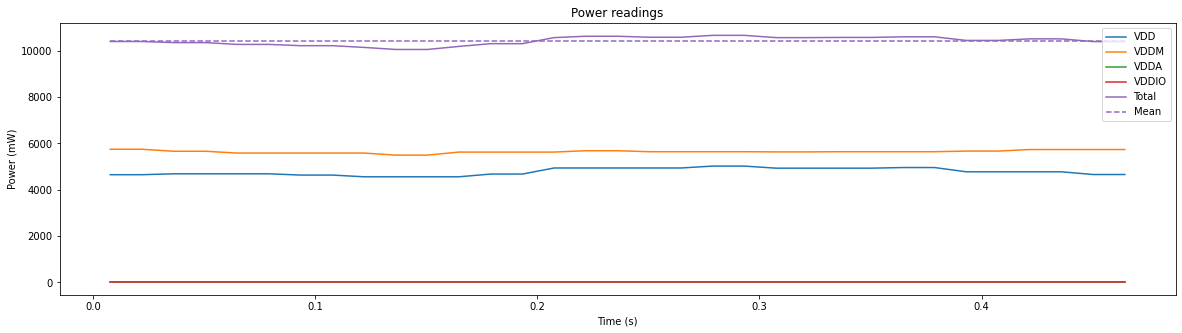

In [12]:
if probeEnergy is True:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20, 5))
    eProbe.plotPower()
    # plt.axis((0, 1, None, None))